<!-- #### Download SWOT L2 HR data 
- swot_l2_hr_pixc data
- swot_l2_hr_raster data -->


#### Data search and downloading using api tool.

In [1]:
import os 
import earthaccess
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely import simplify

In [2]:
dir_pixc = 'data/swot_l2/pixc/dianchi-lake'
## the lake vector is derived by watnet and manually corrected
path_region_vec = 'data/lakes-vec/chenghai_s2_20240418.gpkg'  


In [3]:
region_gpd = gpd.read_file(path_region_vec)
## download by polygon, sometimes it is not working
# region_geo = simplify(region_gpd.union_all(), tolerance=0.001)  # 
# x = region_geo.exterior.coords.xy[0].tolist()
# y = region_geo.exterior.coords.xy[1].tolist()
# region_coords = list(zip(x, y))
# region_coords = region_coords[::-1]  ## counter-clockwise order
# len(region_coords)


In [4]:
auth = earthaccess.login()


<!-- ##### 1. swot_l2_hr_pixc data (main data) -->


##### Downloading using api is slow. the alternative solution is downloading from earthdata website.



In [5]:
time_range = ('2023-01-01 00:00:00', '2024-12-31 23:59:59')  ## temporal range.
links_list = []
data_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0', 
                                    temporal = time_range,
                                    bounding_box = region_gpd.union_all().bounds,
                                    # polygon=region_coords,
                                    )
for r in range(len(data_results)):
    lake_link = earthaccess.results.DataGranule.data_links(data_results[r], access='external')[0]
    links_list.append(lake_link)
print('number of files:', len(links_list))
# earthaccess.download(links_list, dir_pixc)


number of files: 74


In [30]:
## check the downloaded data
paths_file = [os.path.join(dir_pixc, file) for file in os.listdir(dir_pixc) if 'PIXC_' in file and 'readout' not in file]
pixc_nc = xr.open_dataset(paths_file[0], group='pixel_cloud')
pixc_nc


<xarray.Dataset> Size: 1GB
Dimensions:                                (points: 5353470, complex_depth: 2,
                                            num_pixc_lines: 3282)
Coordinates:
    latitude                               (points) float64 43MB ...
    longitude                              (points) float64 43MB ...
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 43MB ...
    range_index                            (points) float64 43MB ...
    interferogram                          (points, complex_depth) float32 43MB ...
    power_plus_y                           (points) float32 21MB ...
    power_minus_y                          (points) float32 21MB ...
    coherent_power                         (points) float32 21MB ...
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 26kB ...
    pixc_line_to_tvp                       (num_pixc_lines) float32 13kB ...
    data_window_first_valid                (num_pixc_lines) float64 26kB ...
    data_window_last_valid                 (num_pixc_lines) float64 26kB ...
    data_window_first_cross_track          (num_pixc_lines) float32 13kB ...
    data_window_last_cross_track           (num_pixc_lines) float32 13kB ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3282
    interferogram_size_range:    5110
    looks_to_efflooks:           1.5535784346443815
    num_azimuth_looks:           7.0
    azimuth_offset:              9

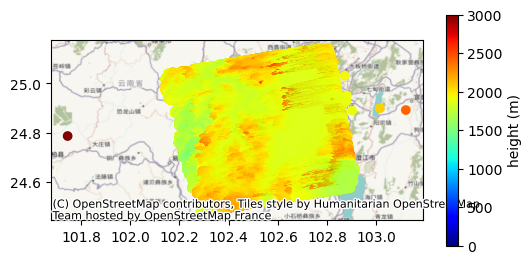

In [37]:
# mask to get good water pixels
fig, ax = plt.subplots(1, 1, figsize=(6,6))
# mask = np.where(np.logical_and(pixc_nc.classification > 2, pixc_nc.geolocation_qual <= 64))
scatter = ax.scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=pixc_nc.height, cmap='jet', vmin=0, vmax=3000)
ctx.add_basemap(ax, crs=region_gpd.crs.to_string())
fig.colorbar(scatter, ax=ax, shrink=0.5).set_label('height (m)')


<!-- ##### 2. swot_l2_hr_raster data (to compare with pixc data.) -->
